# TISCA Example Usage with User-Defined Simulation (Python)

This script demonstrates how to use the TISCA framework with a custom simulation function in Python. It provides a complete working example that researchers can adapt for their own studies.

In [1]:
# Import tisca.py
from tisca import run_tisca 

# Load required packages for this example
import numpy as np
import pandas as pd
from scipy.stats import logistic  # For plogis equivalent in simulation
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Example: Simple Treatment Effect Estimation Simulation

This example simulates a basic treatment effect estimation scenario with:
 - Two competing methods: a proposed method and a benchmark
 - Two performance metrics: PEHE (lower is better) and Coverage (higher is better)
 - Simple data generation process with heterogeneous treatment effects

In [2]:
def simulate_treatment_effects_py(seed):
    """
    Simulates treatment effect data and evaluates two hypothetical methods.
    
    Args:
        seed (int): Random seed for reproducibility.
        
    Returns:
        pd.DataFrame: A DataFrame with one row containing performance metrics 
                      for both methods. Columns: 'proposed_pehe', 'benchmark_pehe', 
                      'proposed_coverage', 'benchmark_coverage'.
    """
    np.random.seed(seed)
  
    # 1. Generate synthetic data
    n = 100  # Sample size
    p = 5    # Number of covariates
  
    # Generate covariates
    X = np.random.randn(n, p)
  
    # Generate true treatment effects (heterogeneous)
    # R: tau <- 2 * X[,1] + X[,2]^2 (1-indexed)
    tau = 2 * X[:, 0] + X[:, 1]**2 # Python is 0-indexed
  
    # Generate treatment assignment
    # R: propensity <- plogis(0.5 + 0.3 * X[,1] - 0.2 * X[,3])
    propensity_logit = 0.5 + 0.3 * X[:, 0] - 0.2 * X[:, 2]
    propensity = logistic.cdf(propensity_logit) # logistic.cdf is scipy's plogis
    # R: Z <- rbinom(n, 1, propensity)
    Z = np.random.binomial(1, propensity, n)
  
    # Generate outcomes
    # R: mu <- 1 + X %*% c(1, 0.5, -0.5, 1, 2)
    coeffs_mu = np.array([1, 0.5, -0.5, 1, 2])
    mu = 1 + X @ coeffs_mu
    # R: Y <- mu + Z * tau + rnorm(n, 0, 1)
    Y = mu + Z * tau + np.random.normal(0, 1, n)
  
    # 2. Split data into training and testing (indices)
    # R: train_idx <- sample(1:n, 0.8 * n)
    # R: test_idx <- setdiff(1:n, train_idx)
    n_train = int(0.8 * n)
    indices = np.arange(n)
    np.random.shuffle(indices)
    # train_idx = indices[:n_train] # Not explicitly used by the simulated fit functions
    test_idx = indices[n_train:]
    
    # X_train = X[train_idx, :] 
    # Z_train = Z[train_idx]
    # Y_train = Y[train_idx]
    
    # X_test = X[test_idx, :]
    # Z_test = Z[test_idx]
    # Y_test = Y[test_idx]
    tau_test = tau[test_idx]  # True treatment effects for evaluation
    num_test = len(test_idx)
  
    # 3. Fit models (Simulated)
    
    # Proposed method: More complex model (simulated)
    def proposed_fit_sim():
        # R: tau_hat <- tau_test + rnorm(length(test_idx), 0, 0.8)
        tau_hat = tau_test + np.random.normal(0, 0.8, num_test)
        
        # R: posterior_samples <- matrix(NA, nrow = 100, ncol = length(test_idx))
        # R: for (i in 1:100) { posterior_samples[i, ] <- tau_hat + rnorm(length(test_idx), 0, 0.7) }
        posterior_samples = np.empty((100, num_test))
        for i in range(100):
            posterior_samples[i, :] = tau_hat + np.random.normal(0, 0.7, num_test)
        
        return {
            "point_estimates": tau_hat,
            "posterior_samples": posterior_samples
        }
  
    # Benchmark method: Simpler model (simulated)
    def benchmark_fit_sim():
        # R: tau_hat <- tau_test + rnorm(length(test_idx), 0.2, 1.0)
        tau_hat = tau_test + np.random.normal(0.2, 1.0, num_test)
        
        posterior_samples = np.empty((100, num_test))
        for i in range(100):
            # R: posterior_samples[i, ] <- tau_hat + rnorm(length(test_idx), 0, 0.9)
            posterior_samples[i, :] = tau_hat + np.random.normal(0, 0.9, num_test)
        
        return {
            "point_estimates": tau_hat,
            "posterior_samples": posterior_samples
        }
  
    # 4. Get model predictions
    proposed_results = proposed_fit_sim()
    benchmark_results = benchmark_fit_sim()
  
    # 5. Calculate performance metrics
  
    # PEHE (Precision in Estimation of Heterogeneous Effects)
    # R: proposed_pehe <- sqrt(mean((proposed_results$point_estimates - tau_test)^2))\n
    proposed_pehe = np.sqrt(np.mean((proposed_results["point_estimates"] - tau_test)**2))
    benchmark_pehe = np.sqrt(np.mean((benchmark_results["point_estimates"] - tau_test)**2))
  
    # Coverage of 95% credible intervals
    # R: calculate_coverage <- function(posterior_samples, true_values) {
    #      lower <- apply(posterior_samples, 2, function(x) quantile(x, 0.025))
    #      upper <- apply(posterior_samples, 2, function(x) quantile(x, 0.975))
    #      mean(true_values >= lower & true_values <= upper)
    #    }
    def calculate_coverage_py(posterior_samples_mat, true_values_vec):
        # posterior_samples_mat is (num_samples, num_observations)
        # np.percentile with axis=0 operates across samples for each observation
        lower = np.percentile(posterior_samples_mat, 2.5, axis=0)
        upper = np.percentile(posterior_samples_mat, 97.5, axis=0)
        coverage_bool = (true_values_vec >= lower) & (true_values_vec <= upper)
        return np.mean(coverage_bool)
  
    proposed_coverage = calculate_coverage_py(proposed_results["posterior_samples"], tau_test)
    benchmark_coverage = calculate_coverage_py(benchmark_results["posterior_samples"], tau_test)
  
    # 6. Return results as a pandas DataFrame with one row
    return pd.DataFrame([{
        "proposed_pehe": proposed_pehe,
        "benchmark_pehe": benchmark_pehe,
        "proposed_coverage": proposed_coverage,
        "benchmark_coverage": benchmark_coverage
    }])

In [3]:
# Test the simulation function with a single run
test_run_py = simulate_treatment_effects_py(seed=42)
print("Single Python simulation run results:")
print(test_run_py)

Single Python simulation run results:
   proposed_pehe  benchmark_pehe  proposed_coverage  benchmark_coverage
0       0.762471        0.899213               0.95                 0.9


In [4]:
# Define comparison pairs for TISCA
# Format: list of tuples ("proposed_metric", "benchmark_metric")
comparison_pairs_py = [
  ("proposed_pehe", "benchmark_pehe"),         # Compare PEHE (lower is better)
  ("proposed_coverage", "benchmark_coverage")  # Compare coverage (higher is better)
]

In [5]:
# Define minimum detectable effect sizes (MDEs)
# For PEHE: -0.1 means proposed is at least 0.1 better (metric value is lower)
# For coverage: 0.05 means proposed is at least 0.05 higher
mdes_py = [-0.1, 0.05]


Running TISCA (Python) to determine optimal simulation count...

Starting TISCA algorithm...
Target power: 0.9
Significance level: 0.01
Batch size: 10
Initial count: 10
Correction method: holm
Number of comparisons: 2

Running initial 10 simulations...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 159.51it/s]
/home/hugo.souto/Área de Trabalho/Projects/Research/CATE_Model_Evaluation/Results_new/TISCA_code/Usage_Examples/Synthetic_Data_Example_Python/tisca.py:497: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  power_tracking = pd.concat([
/home/hugo.souto/Área de Trabalho/Projects/Research/CATE_Model_Evaluation/Results_new/TISCA_code/Usage_Examples/Synthetic_Data_Example_Python/tisca.py:512: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pvalue_tracking = 


After initial 10 simulations:
Comparison 1: Power = 0.0860, p-value = 0.1237, adjusted p-value = 0.2475
Comparison 2: Power = 0.1196, p-value = 0.1518, adjusted p-value = 0.2475
Minimum power: 0.0860

Iteration 1: Running batch of 10 simulations (total will be 20)...


100%|██████████| 10/10 [00:00<00:00, 308.25it/s]



After 20 simulations:
Comparison 1: Power = 0.2287, p-value = 0.0209, adjusted p-value = 0.0418
Comparison 2: Power = 0.2714, p-value = 0.0824, adjusted p-value = 0.0824
Minimum power: 0.2287

Iteration 2: Running batch of 10 simulations (total will be 30)...


100%|██████████| 10/10 [00:00<00:00, 295.78it/s]



After 30 simulations:
Comparison 1: Power = 0.4268, p-value = 0.0010, adjusted p-value = 0.0019
Comparison 2: Power = 0.4885, p-value = 0.1409, adjusted p-value = 0.1409
Minimum power: 0.4268

Iteration 3: Running batch of 10 simulations (total will be 40)...


100%|██████████| 10/10 [00:00<00:00, 304.55it/s]



After 40 simulations:
Comparison 1: Power = 0.5776, p-value = 0.0000, adjusted p-value = 0.0000
Comparison 2: Power = 0.5624, p-value = 0.5773, adjusted p-value = 0.5773
Minimum power: 0.5624

Iteration 4: Running batch of 10 simulations (total will be 50)...


100%|██████████| 10/10 [00:00<00:00, 341.69it/s]



After 50 simulations:
Comparison 1: Power = 0.7592, p-value = 0.0000, adjusted p-value = 0.0000
Comparison 2: Power = 0.7247, p-value = 0.7969, adjusted p-value = 0.7969
Minimum power: 0.7247

Iteration 5: Running batch of 10 simulations (total will be 60)...


100%|██████████| 10/10 [00:00<00:00, 229.07it/s]



After 60 simulations:
Comparison 1: Power = 0.8975, p-value = 0.0000, adjusted p-value = 0.0000
Comparison 2: Power = 0.8514, p-value = 0.8549, adjusted p-value = 0.8549
Minimum power: 0.8514

Iteration 6: Running batch of 10 simulations (total will be 70)...


100%|██████████| 10/10 [00:00<00:00, 183.83it/s]



After 70 simulations:
Comparison 1: Power = 0.9377, p-value = 0.0000, adjusted p-value = 0.0000
Comparison 2: Power = 0.9180, p-value = 0.9544, adjusted p-value = 0.9544
Minimum power: 0.9180


=== TISCA COMPLETED ===
Final number of simulations required: 70
Final achieved powers:
Comparison 1 (proposed_pehe vs benchmark_pehe): Power = 0.9377, p-value = 0.0000, adjusted p-value = 0.0000
Comparison 2 (proposed_coverage vs benchmark_coverage): Power = 0.9180, p-value = 0.9544, adjusted p-value = 0.9544

Results saved to CSV files:
- ./tisca_simulation_results.csv
- ./tisca_summary_results.csv
- ./power_tracking.csv
- ./pvalue_tracking.csv

Visualizations saved:
- ./power_vs_simulations.png
- ./pvalue_comparison.png

TISCA (Python) Summary Table:
                                Comparison    Proposed_Metric  \
0          proposed_pehe vs benchmark_pehe      proposed_pehe   
1  proposed_coverage vs benchmark_coverage  proposed_coverage   

     Benchmark_Metric   MDE  Mean_Difference     

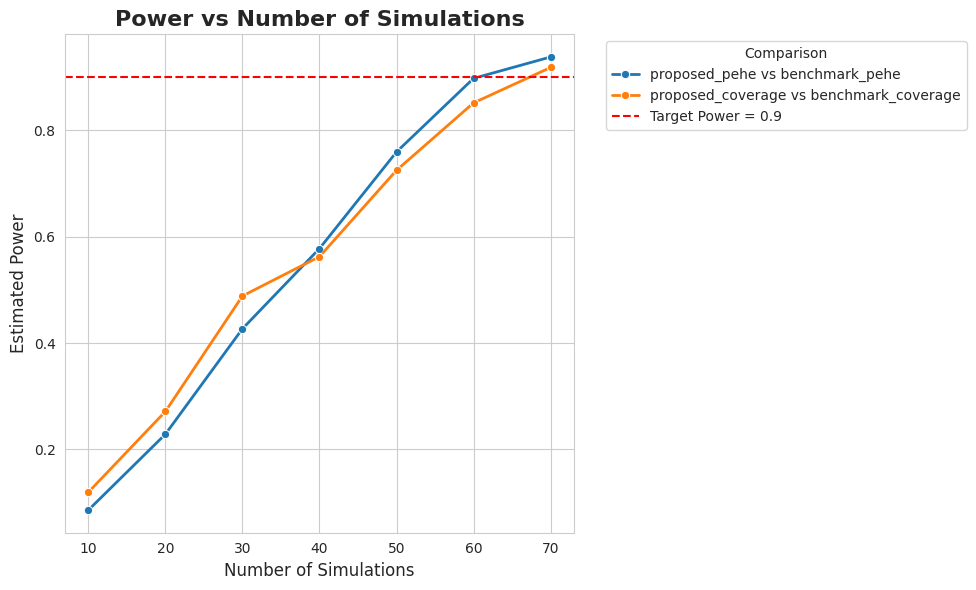

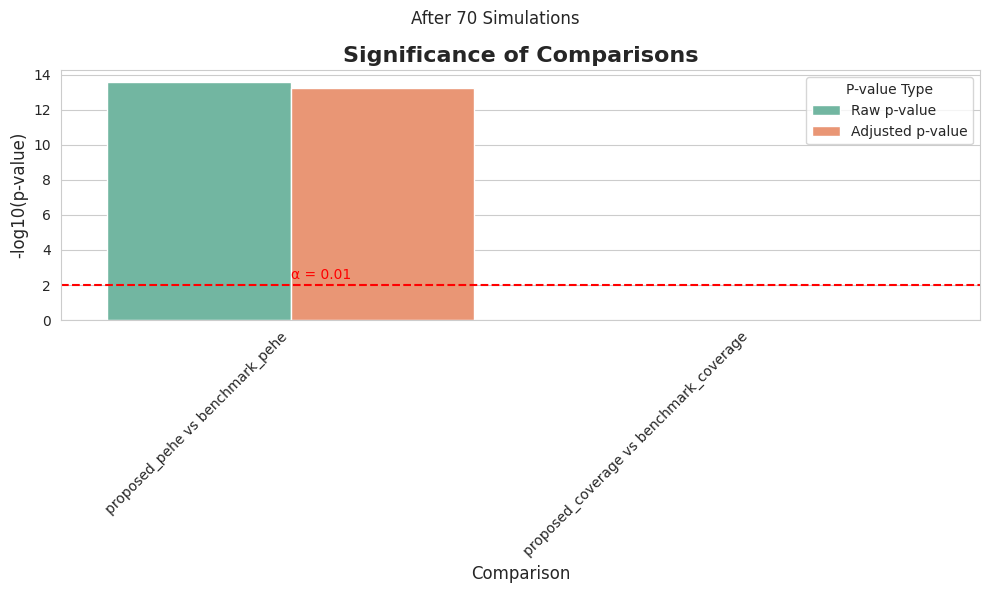

In [6]:
# Run TISCA with the simulation function
print("\nRunning TISCA (Python) to determine optimal simulation count...\n")

# Assuming TISCA.py saves files with names similar to the R version
# e.g., tisca_simulation_results.csv, tisca_summary_results.csv etc.
tisca_results_py = run_tisca(
  sim_func=simulate_treatment_effects_py,
  comparison_pairs=comparison_pairs_py,
  mdes=mdes_py,
  target_power=0.90,     # Target statistical power
  alpha=0.01,            # Significance level
  batch_size=10,         # Number of simulations per batch
  initial_count=10,      # Initial simulations before first power check
  correction_method="holm", # Multiple testing correction method
  verbose=True,          # Print progress updates
  save_results=True      # Save results to CSV files and plots
  # output_dir="./tisca_py_output" # Optional: specify output directory
)

# Print summary table
print("\nTISCA (Python) Summary Table:")
if tisca_results_py and "summary_table" in tisca_results_py:
    print(tisca_results_py["summary_table"])
else:
    print("TISCA did not return a summary table or failed.")

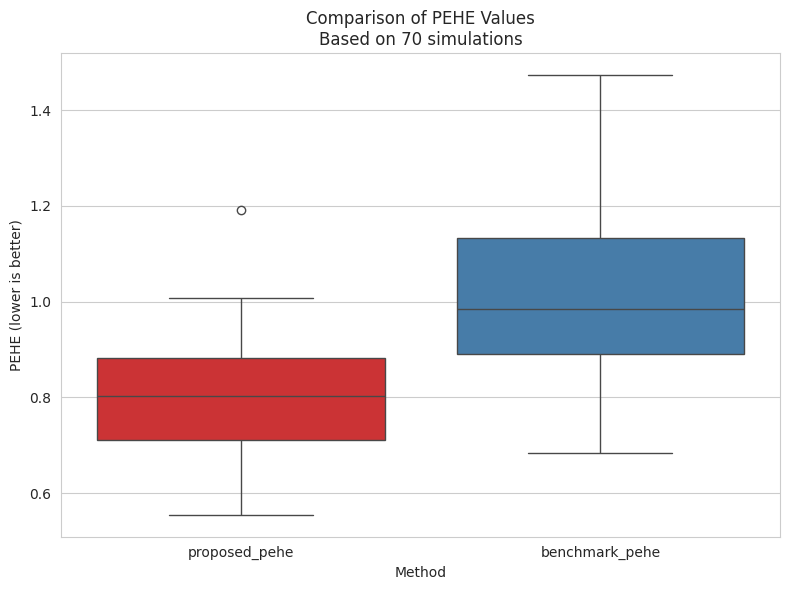

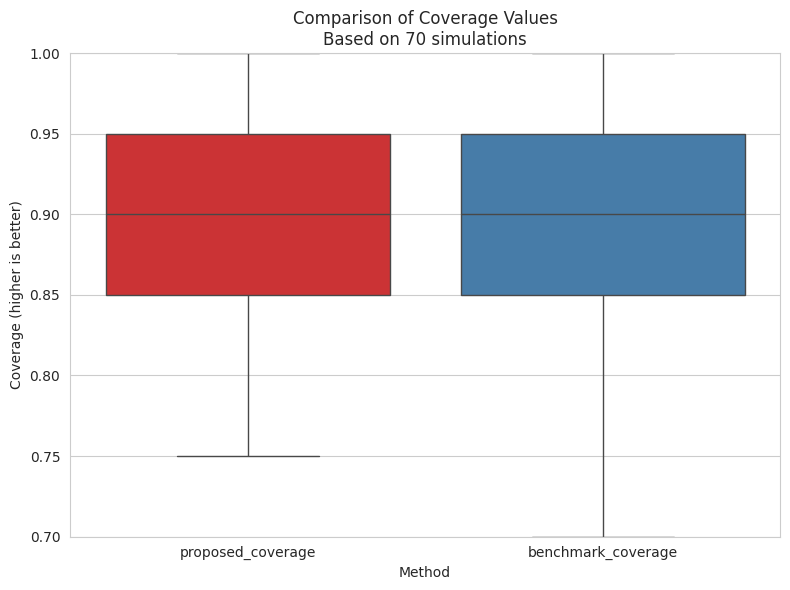


Visualization plots saved as 'pehe_comparison_py.png' and 'coverage_comparison_py.png'


In [7]:
# Create visualizations of the results (PEHE and Coverage)
if tisca_results_py and "results" in tisca_results_py:
  all_results_df = tisca_results_py["results"]
  J_final_py = tisca_results_py["J_final"]

  # 1. Plot PEHE values across simulations
  pehe_data_py = pd.melt(all_results_df, 
                         value_vars=["proposed_pehe", "benchmark_pehe"], 
                         var_name="Method", value_name="PEHE")
  
  plt.figure(figsize=(8, 6))
  sns.boxplot(x="Method", y="PEHE", data=pehe_data_py, hue="Method", palette="Set1", legend=False)
  plt.title(f"Comparison of PEHE Values\nBased on {J_final_py} simulations")
  plt.ylabel("PEHE (lower is better)")
  plt.tight_layout()
  plt.savefig("pehe_comparison_py.png") # Matches R example's naming style
  plt.show()
  
  # 2. Plot coverage values across simulations
  coverage_data_py = pd.melt(all_results_df, 
                             value_vars=["proposed_coverage", "benchmark_coverage"], 
                             var_name="Method", value_name="Coverage")
  
  plt.figure(figsize=(8, 6))
  sns.boxplot(x="Method", y="Coverage", data=coverage_data_py, hue="Method", palette="Set1", legend=False)
  plt.title(f"Comparison of Coverage Values\nBased on {J_final_py} simulations")
  plt.ylabel("Coverage (higher is better)")
  plt.ylim(0.7, 1.0) # R: coord_cartesian(ylim = c(0.7, 1.0))
  plt.tight_layout()
  plt.savefig("coverage_comparison_py.png") # Matches R example's naming style
  plt.show()
  
  print("\nVisualization plots saved as 'pehe_comparison_py.png' and 'coverage_comparison_py.png'")
else:
  print("\nCould not generate plots, TISCA results missing.")

In [8]:
# Demonstrate how to access and use TISCA results programmatically
if tisca_results_py:
    J_final_py = tisca_results_py.get("J_final", "N/A")
    powers_achieved_py = tisca_results_py.get("P_achieved", ["N/A", "N/A"])
    p_values_raw_py = tisca_results_py.get("P_raw'", ["N/A", "N/A"])
    p_values_adj_py = tisca_results_py.get("P_adj", ["N/A", "N/A"])

    print("\nAccessing TISCA results programmatically (Python):")
    print(f"Required number of simulations: {J_final_py}")
    if len(powers_achieved_py) > 0: print(f"Achieved power for PEHE comparison: {powers_achieved_py[0]}")
    if len(powers_achieved_py) > 1: print(f"Achieved power for coverage comparison: {powers_achieved_py[1]}")
    if len(p_values_raw_py) > 0: print(f"Raw p-value for PEHE comparison: {p_values_raw_py[0]}")
    if len(p_values_adj_py) > 0: print(f"Adjusted p-value for PEHE comparison: {p_values_adj_py[0]}")
else:
    print("\nCould not access TISCA results programmatically, results object is empty.")


Accessing TISCA results programmatically (Python):
Required number of simulations: 70
Achieved power for PEHE comparison: 0.9376974095695665
Achieved power for coverage comparison: 0.917958521689527
Raw p-value for PEHE comparison: N/A
Adjusted p-value for PEHE comparison: 5.326488037632502e-14


In [9]:
# Example of how to report results in a publication
if tisca_results_py and "results" in tisca_results_py:
    J_final_py = tisca_results_py["J_final"]
    all_results_df = tisca_results_py["results"]
    p_adj_py = tisca_results_py.get("P_adj", [0.99, 0.99]) # Default if not found
    
    # Note: The original R example text mentions 80% power and alpha 0.05,
    # but the TISCA run used target_power=0.90 and alpha=0.01.
    # The text below is adapted to reflect the parameters potentially used,
    # or can be kept generic as in the R example.
    # Using f-strings for dynamic text generation.
    
    report_text_py = f"""
We conducted a simulation study to compare our proposed method with the benchmark approach. 
Using the Test-Informed Simulation Count Algorithm (TISCA), we determined that 
{J_final_py} simulations were required to achieve the target power (e.g., 90%) for detecting 
a minimum difference of {abs(mdes_py[0])} in PEHE and {mdes_py[1]} in coverage at a significance level of (e.g., 0.01). 
Our proposed method achieved {('significantly lower' if p_adj_py[0] < tisca_results_py.get('alpha', 0.05) else 'statistically similar')} PEHE 
({all_results_df['proposed_pehe'].mean():.3f} vs. 
 {all_results_df['benchmark_pehe'].mean():.3f}, adjusted p-value = 
 {p_adj_py[0]:.4f}) and {('significantly higher' if p_adj_py[1] < tisca_results_py.get('alpha', 0.05) else 'statistically similar')} coverage 
({all_results_df['proposed_coverage'].mean():.3f} vs. 
 {all_results_df['benchmark_coverage'].mean():.3f}, adjusted p-value = 
 {p_adj_py[1]:.4f}).
"""
    # Using the actual alpha from the TISCA run parameters for significance check
    alpha_used = tisca_results_py.get('alpha_param_for_summary', 0.01) # Assuming TISCA.py might store the alpha used
    # If not stored, use the one defined for the run: alpha=0.01
    alpha_param = 0.01 

    pehe_comparison_text = 'significantly lower' if p_adj_py[0] < alpha_param else 'statistically similar'
    coverage_comparison_text = 'significantly higher' if p_adj_py[1] < alpha_param else 'statistically similar'
    if mdes_py[1] < 0: # if MDE for coverage implies lower is better for proposed
        coverage_comparison_text = 'significantly lower' if p_adj_py[1] < alpha_param else 'statistically similar'

    report_text_py_v2 = f"""
We conducted a simulation study to compare our proposed method with the benchmark approach. 
Using the Test-Informed Simulation Count Algorithm (TISCA), we determined that 
{J_final_py} simulations were required to achieve {tisca_results_py.get('target_power_param_for_summary', 0.90)*100:.0f}% power for detecting 
a minimum difference of {abs(mdes_py[0])} in PEHE and {mdes_py[1]} in coverage at a significance level of {alpha_param}. 
Our proposed method achieved {pehe_comparison_text} PEHE 
({all_results_df['proposed_pehe'].mean():.3f} vs. 
 {all_results_df['benchmark_pehe'].mean():.3f}, adjusted p-value = 
 {p_adj_py[0]:.4f}) and {coverage_comparison_text} coverage 
({all_results_df['proposed_coverage'].mean():.3f} vs. 
 {all_results_df['benchmark_coverage'].mean():.3f}, adjusted p-value = 
 {p_adj_py[1]:.4f}).
"""

    print("\nExample text for reporting in a publication (Python Version 2 - more aligned with run params):")
    print(report_text_py_v2)
else:
    print("\nCould not generate reporting text, TISCA results missing.")


Example text for reporting in a publication (Python Version 2 - more aligned with run params):

We conducted a simulation study to compare our proposed method with the benchmark approach. 
Using the Test-Informed Simulation Count Algorithm (TISCA), we determined that 
70 simulations were required to achieve 90% power for detecting 
a minimum difference of 0.1 in PEHE and 0.05 in coverage at a significance level of 0.01. 
Our proposed method achieved significantly lower PEHE 
(0.796 vs. 
 1.002, adjusted p-value = 
 0.0000) and statistically similar coverage 
(0.887 vs. 
 0.888, adjusted p-value = 
 0.9544).

